## Arrest phase diagram for pulses with stress barrier:

We set up pulses for arrest using the steady state solution (choose $u(0) = 2\tau/\gamma$). This reduces the arrest length approximation to

\begin{equation}
L_{arrest} = \frac{2 \log(\frac{\tau_{barrier} - \tau}{\tau_{barrier}})}{\gamma}
\end{equation}

In the following, we set up a fixed $\gamma = 0.7$ and vary $\tau$ and $\tau_{barrier}$ to create a 2D phase diagram of the arrest length


In [1]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal
import scipy as scp
import scipy.io as sio
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Friction classes for alternative friction laws:
class SlipWeakeningFrictionLaw: 
    
    def __init__(self,dc,delta_u):
        self.dc = dc
        self.delta_u = delta_u
        
    def getFriction(self,x,u,v,tau,stuck):
        frictionForce = np.sign(v)*(1-self.delta_u/self.dc)
        frictionForce[frictionForce<0]=0
        return frictionForce
    
    def step(self,x,u,v,tau,stuck,dt):
        self.delta_u = self.delta_u + v*dt
        self.delta_u[stuck==1]=0 #Arrest sets delta_u to zero
        return
    

In [3]:
#Gauss distribution for setting up initial stress
def gauss(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2*sigma**2))

In [4]:
# Create pulse prediction function
def PulsePrediction(startPos,u,x,tau,gamma,dc=0):
    u_pred = np.zeros(np.size(x))
    u_pred[startPos]=u[startPos,-1]
    if len([dc])==1:
        dc = dc*np.ones(np.size(x))

    for i in range(startPos+1,len(x)):        
        dx = x[i]-x[i-1]
        u_pred[i] = u_pred[i-1] + (tau[i-1] - .5*gamma*u_pred[i-1])*dx
        
        #Fracture energy mod:
        if u_pred[i-1]<dc[i-1]:
            u_pred[i] = u_pred[i] - (1-u_pred[i-1]/(2*dc[i-1]))*dx
        else:
            u_pred[i] = u_pred[i] - .5*dc[i-1]/(u_pred[i-1])*dx

    # Prediction of arrest where u_pred<0
    try:
        ind = np.where(u_pred<0)
        u_pred[ind[0][0]:]=0
    except:
        pass
    
    return u_pred

In [5]:
generate_data = False

gamma = 0.65
barrier_x = 40
dt = 5e-3
tmax = 200
beta = 1e-3
output_interval = 10
x = np.linspace(0,100,1000)

if generate_data:
    
    tau_all = np.logspace(-2,0,5) #TODO: 25x25
    tau_barrier_all = -np.logspace(-2,0,5)

    L_arrest = np.zeros([np.size(tau_all),np.size(tau_barrier_all)])

    data = []

    for i in range(np.size(tau_all)):
        for j in range(np.size(tau_barrier_all)):

            tau = gauss(x,0,1)*(1-tau_all[i]) + tau_all[i]
            tau[0]=1
            tau[x>barrier_x]=tau_barrier_all[j]

            # run
            data.append(run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta))

            # Find L_arrest
            L_arrest[i,j]=x[np.max(np.where(data[-1]['u'][:,-1]>0))]-barrier_x

    pickle.dump({'data': data, 'L_arrest': L_arrest, 'tau_barrier_all': tau_barrier_all, 'tau_all': tau_all},  open( "data_figure_pulse_stress_barrier.p", "wb" ))
else:
    data = pickle.load( open( "data_figure_pulse_stress_barrier.p", "rb" ) )
    L_arrest = data['L_arrest']
    tau_all = data['tau_all']
    tau_barrier_all = data['tau_barrier_all']
        

In [6]:
# Calculate prediction:
tau_all_pred = np.logspace(-2,0,250)
tau_barrier_all_pred = -np.logspace(-2,0,250)
L_arrest_pred = np.zeros([np.size(tau_all_pred),np.size(tau_barrier_all_pred)])

x_barrier = 40
for i in range(np.size(tau_all_pred)):
    for j in range(np.size(tau_barrier_all_pred)):
        L_arrest_pred[i,j]=2/gamma*np.log((tau_barrier_all_pred[j]-tau_all_pred[i])/tau_barrier_all_pred[j])
        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


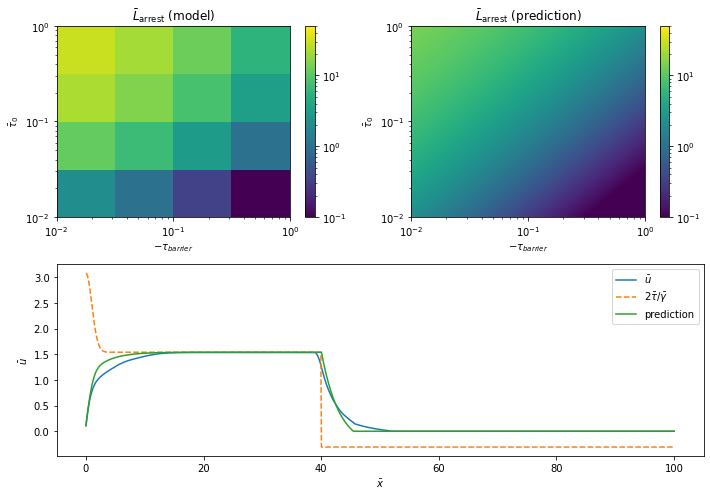

In [7]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
L = L_arrest
L[L<=1e-1]=1e-1
plt.pcolormesh(-tau_barrier_all,tau_all,L,norm=colors.LogNorm(vmin=1e-1, vmax=50))
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.xlabel('$-\\tau_{barrier}$')
plt.ylabel('$\\bar \\tau_0$')
plt.title('$\\bar L_\mathrm{arrest}$ (model)')

plt.subplot(2,2,2)
plt.pcolormesh(-tau_barrier_all_pred,tau_all_pred,L_arrest_pred,norm=colors.LogNorm(vmin=1e-1, vmax=50))
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$-\\tau_{barrier}$')
plt.ylabel('$\\bar \\tau_0$')
plt.title('$\\bar L_\mathrm{arrest}$ (prediction)')

plt.subplot(2,2,(3,4))
x = np.linspace(0,100,1000)
tau = gauss(x,0,1)*(1-.5) + .5
tau[0]=1
tau[x>barrier_x]=-.1
data = run.run_continuum(x = x, tau = tau, tau_minus = tau+2, dt = dt, output_interval = output_interval, gamma = gamma, tmax = tmax, beta = beta)
u_pred = PulsePrediction(startPos = 0, u = data['u'], x = data['x'],tau = data['tau'], gamma = data['gamma'],dc = 0)

plt.plot(data['x'],data['u'][:,-1],label='$\\bar u$')
plt.plot(data['x'],2*data['tau']/data['gamma'],label='$2\\bar \\tau/\\bar \\gamma$',linestyle='--')
plt.plot(data['x'],u_pred,label='prediction',linestyle='-')    
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar u$')    
plt.legend()
plt.tight_layout()

plt.savefig('arrest_length_tau.eps', format='eps')

plt.show()